In [3]:
!chmod 600 /root/.kaggle/kaggle.json
!pip install --upgrade pip
!pip install --upgrade kaggle pandas matplotlib scikit-learn tensorflow-hub==0.13.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 3.5 MB/s eta 0:00:00ta 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 1.5 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.6/100.6 kB 1.9 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 4.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 11.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 10.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 505.5/505.5 kB 12.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 15.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.4/345.4 kB 18.5 MB/s eta 0:00:00
   ━━━━

# Project Goal and Overview
The goal of this project is to create a Generative Adversarial Network (GAN) to convert images into the monet style.  To do this, I will use the 300 monet images to perform the training.  There are 300 Monets, and 7000+ photos.



In [4]:
import kaggle
import zipfile
import tensorflow.keras as keras
from keras import layers
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import matplotlib.image as mpimg
import random
import math
from scipy import linalg
import pathlib
import urllib
import pickle

from __future__ import absolute_import, division, print_function
import gzip, pickle
from scipy import linalg
import pathlib
import urllib
import warnings
from tqdm import tqdm
from PIL import Image
import pandas as pd
import requests
from os import getcwd
import tarfile
import tensorflow_hub as hub

autotune = tf.data.AUTOTUNE
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import warnings
warnings.filterwarnings("ignore")
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

2024-06-07 20:33:01.300099: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-07 20:33:01.300132: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-07 20:33:01.301104: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-07 20:33:01.306835: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.15.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-06-07 20:33:03.508210: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-07 20:33:03.513047: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-07 20:33:03.513290: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

# Data Description
The data is 2 sets of 256x256x3 color photos.  300 are monet paintings, and ~7000 are just ordinary photos.  Images are in a TFREC (Tensor Flow Record) format, which is convienient ofr easy batching.  

In [5]:
# Create folders as I did my work off kaggle.

tmp_dir = getcwd() + "/kaggle/tmp/"
input_dir = getcwd() + "/kaggle/input/"
working_dir = getcwd() + "/kaggle/working/"
if not os.path.exists(getcwd() + "/kaggle"):
    os.makedirs(getcwd() + "/kaggle")
if not os.path.exists(getcwd() + "/kaggle/tmp"):
    os.makedirs(getcwd() + "/kaggle/tmp")
if not os.path.exists(getcwd() + "/kaggle/tmp/images"):
    os.makedirs(getcwd() + "/kaggle/tmp/images")
if not os.path.exists(getcwd() + "/kaggle/working"):
    os.makedirs(getcwd() + "/kaggle/working")

In [6]:
if not os.path.exists(getcwd() + "kaggle/input/"):
    !kaggle competitions download -c 'gan-getting-started'
    #!mkdir kaggle
    #!mkdir kaggle/input
    #!mkdir kaggle/input/gan-getting-started
    #!unzip -qq gan-getting-started.zip -d kaggle/input/gan-getting-started
    with zipfile.ZipFile('gan-getting-started.zip', 'r') as zip_ref:
        zip_ref.extractall(f"{input_dir}gan-getting-started")

 97%|██████████████████████████████████████▉ | 357M/367M [00:08<00:00, 78.2MB/s]
100%|████████████████████████████████████████| 367M/367M [00:08<00:00, 44.1MB/s]


In [7]:

def count_files_in_directory(directory_path):
    # List all files in the directory
    files = [f for f in os.listdir(directory_path) if os.path.isfile(
        os.path.join(directory_path, f))]
    # Count the number of files
    file_count = len(files)
    return file_count
directory_path = f'{input_dir}gan-getting-started/monet_jpg'
file_count = count_files_in_directory(directory_path)
print(f'There are {file_count} Monet Images.')

directory_path = f'{input_dir}gan-getting-started/photo_jpg'
file_count = count_files_in_directory(directory_path)
print(f'There are {file_count} Photo Images.')

There are 300 Monet Images.
There are 7038 Photo Images.


# EDA
I did some basic looking at the various images to see what I got.  I also looked at T-SNE and Color Density Plots of the 2 data sets.  

20 Monet Images above 20 Photos


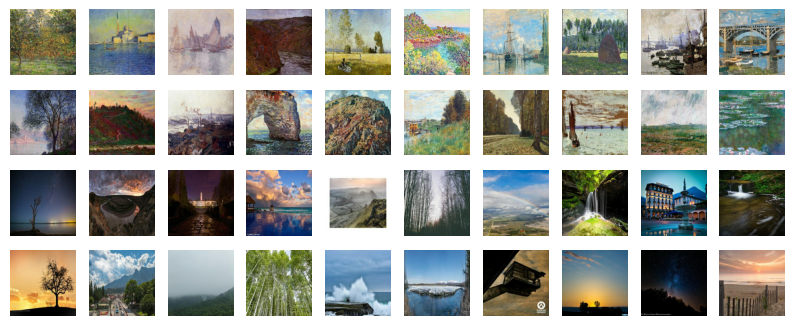

In [8]:
#Generated by Gemini AI but modified to actually work
# Get a list of all the files in the Monet directory
monet_files = os.listdir(f"{input_dir}gan-getting-started/monet_jpg")

# Get a list of all the files in the photo directory
photo_files = os.listdir(f"{input_dir}gan-getting-started/photo_jpg")

# Select 20 random Monet images
random_monet_files = random.sample(monet_files, 20)

# Select 20 random photo images
random_photo_files = random.sample(photo_files, 20)

# Create a 10x2 grid of subplots
fig, axes = plt.subplots(4, 10, figsize=(10, 4))
print("20 Monet Images above 20 Photos")

# Plot the Monet images in the first column

for i, filename in enumerate(random_monet_files):
    img = mpimg.imread(os.path.join(f"{input_dir}/gan-getting-started/monet_jpg", filename))
    axes[math.floor(i%2), math.floor(i/2)].imshow(img)
    axes[math.floor(i%2), math.floor(i/2)].axis('off')

## Plot the photo images in the second column
for i, filename in enumerate(random_photo_files):
    img = mpimg.imread(os.path.join(f"{input_dir}gan-getting-started/photo_jpg", filename))
    axes[math.floor(i%2+2), math.floor(i/2)].imshow(img)
    axes[math.floor(i%2+2), math.floor(i/2)].axis('off')

# Show the plot
plt.show()


# Data Loading and Batch Sizes
In order to perform faster data loading, I chose to load the tfrec files.  I seleted batch sizes to meet GPU memory limitations.

In [9]:
def count_elements(dataset):
    count = 0
    for _ in dataset:
        count += 1
    return count

def decode_image(image):
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize(image, [256, 256])
  return image

def read_tfrecord(example):
  features = {
    'image': tf.io.FixedLenFeature([], tf.string),
  }
  example = tf.io.parse_single_example(example, features)
  image = decode_image(example['image'])
  return image
tfrecord_dir = f"{input_dir}gan-getting-started/monet_tfrec"
tfrecord_files = [os.path.join(tfrecord_dir, f) for f in os.listdir(
    tfrecord_dir) if f.endswith('.tfrec')]
monet_images_dataset = tf.data.TFRecordDataset(
    tfrecord_files).map(read_tfrecord)

tfrecord_dir = f"{input_dir}gan-getting-started/photo_tfrec"
tfrecord_files = [os.path.join(tfrecord_dir, f) for f in os.listdir(
    tfrecord_dir) if f.endswith('.tfrec')]
photo_images_dataset = tf.data.TFRecordDataset(
    tfrecord_files).map(read_tfrecord)

print(monet_images_dataset)
print(f"There are {count_elements(monet_images_dataset)} Monet images")
print(f"There are {count_elements(photo_images_dataset)} Photo images")


2024-06-07 20:33:17.096025: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-07 20:33:17.096340: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-07 20:33:17.096550: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

<_MapDataset element_spec=TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None)>
There are 300 Monet images
There are 7038 Photo images


In [10]:
# https://keras.io/examples/generative/cyclegan/
# Define the standard image size.
orig_img_size = (256, 256)
# Size of the random crops to be used during training.
input_img_size = (256, 256, 3)
# Weights initializer for the layers.
kernel_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
# Gamma initializer for instance normalization.
gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)


def normalize_img(img):
    img = tf.cast(img, dtype=tf.float32)
    # Map values in the range [-1, 1]
    return (img / 127.5) - 1.0
def preprocess_train_image(img):
    # Random flip
    print(img)
    img = tf.image.random_flip_left_right(img)
    # Resize to the original size first
    img = tf.image.resize(img, [*orig_img_size])
    # Random crop to 256X256
    img = tf.image.random_crop(img, size=[*input_img_size])
    # Normalize the pixel values in the range [-1, 1]
    img = normalize_img(img)
    return img


In [11]:
img_size = 256
image_depth = 3
batch_size = 1
LR = 0.00012
buffer_size = 150

In [12]:
# prompt: split TFRecordDataset into a train and test set 80/20 split

# Apply the preprocessing operations to the training data
monet_train_dataset = (
    monet_images_dataset.map(preprocess_train_image, num_parallel_calls=autotune)
    .cache()
    .shuffle(buffer_size)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

# Apply the preprocessing operations to the test data
photo_train_dataset = (
    photo_images_dataset.map(preprocess_train_image, num_parallel_calls=autotune)
    .cache()
    .shuffle(buffer_size)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)
print(f'Photo Images Count {count_elements(photo_train_dataset)}')

print(f'Monet Images Count {count_elements(monet_train_dataset)}')
all_batches = []
for batch in monet_train_dataset:
    # Convert each batch to a NumPy array and append to the list
    all_batches.append(batch.numpy())
    break
print(all_batches[0].shape)

#for i, img in enumerate(monet_test_dataset.take(1)):
#    #print(f"Image {i}: {img}")
 #   plt.imshow(img[0] * 127.5 + 127.5)
 #   plt.title(f"Image {i}")
#    plt.axis('off')
#    plt.show()

Tensor("args_0:0", shape=(256, 256, 3), dtype=float32)
Tensor("args_0:0", shape=(256, 256, 3), dtype=float32)
Photo Images Count 7038
Monet Images Count 300
(1, 256, 256, 3)


#  Starting off the GAN
I used https://keras.io/examples/generative/cyclegan/ as a reference for the initial model build.

In [13]:
# Implementing Instance Normalization due to TFA compatability 
class InstanceNormalization(tf.keras.layers.Layer):
    def __init__(self, epsilon=1e-5, gamma_initializer='ones', beta_initializer='zeros'):
        super(InstanceNormalization, self).__init__()
        self.epsilon = epsilon
        self.gamma_initializer = gamma_initializer
        self.beta_initializer = beta_initializer

    def build(self, input_shape):
        self.gamma = self.add_weight(shape=(input_shape[-1],),
                                     initializer=self.gamma_initializer,
                                     trainable=True)
        self.beta = self.add_weight(shape=(input_shape[-1],),
                                    initializer=self.beta_initializer,
                                    trainable=True)

    def call(self, inputs):
        mean, variance = tf.nn.moments(inputs, axes=[1, 2], keepdims=True)
        normalized = (inputs - mean) / tf.sqrt(variance + self.epsilon)
        return self.gamma * normalized + self.beta 

In [14]:


class ReflectionPadding2D(layers.Layer):
    """Implements Reflection Padding as a layer.

    Args:
        padding(tuple): Amount of padding for the
        spatial dimensions.

    Returns:
        A padded tensor with the same type as the input tensor.
    """

    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        super().__init__(**kwargs)

    def call(self, input_tensor, mask=None):
        padding_width, padding_height = self.padding
        padding_tensor = [
            [0, 0],
            [padding_height, padding_height],
            [padding_width, padding_width],
            [0, 0],
        ]
        return tf.pad(input_tensor, padding_tensor, mode="REFLECT")


def residual_block(
    x,
    activation,
    kernel_initializer=kernel_init,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding="valid",
    gamma_initializer=gamma_init,
    use_bias=False,
):
    dim = x.shape[-1]
    input_tensor = x

    x = ReflectionPadding2D()(input_tensor)
    x = layers.Conv2D(
        dim,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = activation(x)

    x = ReflectionPadding2D()(x)
    x = layers.Conv2D(
        dim,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = layers.add([input_tensor, x])
    return x


def downsample(
    x,
    filters,
    activation,
    kernel_initializer=kernel_init,
    kernel_size=(3, 3),
    strides=(2, 2),
    padding="same",
    gamma_initializer=gamma_init,
    use_bias=False,
):
    x = layers.Conv2D(
        filters,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    if activation:
        x = activation(x)
    return x


def upsample(
    x,
    filters,
    activation,
    kernel_size=(3, 3),
    strides=(2, 2),
    padding="same",
    kernel_initializer=kernel_init,
    gamma_initializer=gamma_init,
    use_bias=False,
):
    x = layers.Conv2DTranspose(
        filters,
        kernel_size,
        strides=strides,
        padding=padding,
        kernel_initializer=kernel_initializer,
        use_bias=use_bias,
    )(x)
    x = InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    if activation:
        x = activation(x)
    return x


In [15]:
def get_resnet_generator(
    filters=64,
    num_downsampling_blocks=2,
    num_residual_blocks=9,
    num_upsample_blocks=2,
    gamma_initializer=gamma_init,
    name=None,
):
    img_input = layers.Input(shape=input_img_size, name=name + "_img_input")
    x = ReflectionPadding2D(padding=(3, 3))(img_input)
    x = layers.Conv2D(filters, (7, 7), kernel_initializer=kernel_init, use_bias=False)(
        x
    )
    x = InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = layers.Activation("relu")(x)

    # Downsampling
    for _ in range(num_downsampling_blocks):
        filters *= 2
        x = downsample(x, filters=filters, activation=layers.Activation("relu"))

    # Residual blocks
    for _ in range(num_residual_blocks):
        x = residual_block(x, activation=layers.Activation("relu"))

    # Upsampling
    for _ in range(num_upsample_blocks):
        filters //= 2
        x = upsample(x, filters, activation=layers.Activation("relu"))

    # Final block
    x = ReflectionPadding2D(padding=(3, 3))(x)
    x = layers.Conv2D(3, (7, 7), padding="valid")(x)
    x = layers.Activation("tanh")(x)

    model = keras.models.Model(img_input, x, name=name)
    return model


In [16]:
def get_discriminator(
    filters=64, kernel_initializer=kernel_init, num_downsampling=3, name=None
):
    img_input = layers.Input(shape=input_img_size, name=name + "_img_input")
    x = layers.Conv2D(
        filters,
        (4, 4),
        strides=(2, 2),
        padding="same",
        kernel_initializer=kernel_initializer,
    )(img_input)
    x = layers.LeakyReLU(0.2)(x)

    num_filters = filters
    for num_downsample_block in range(3):
        num_filters *= 2
        if num_downsample_block < 2:
            x = downsample(
                x,
                filters=num_filters,
                activation=layers.LeakyReLU(0.2),
                kernel_size=(4, 4),
                strides=(2, 2),
            )
        else:
            x = downsample(
                x,
                filters=num_filters,
                activation=layers.LeakyReLU(0.2),
                kernel_size=(4, 4),
                strides=(1, 1),
            )

    x = layers.Conv2D(
        1, (4, 4), strides=(1, 1), padding="same", kernel_initializer=kernel_initializer
    )(x)

    model = keras.models.Model(inputs=img_input, outputs=x, name=name)
    return model


In [17]:
class CycleGan(keras.Model):
    def __init__(
        self,
        generator_G,
        generator_F,
        discriminator_X,
        discriminator_Y,
        lambda_cycle=10.0,
        lambda_identity=0.5,
    ):
        super().__init__()
        self.gen_G = generator_G
        self.gen_F = generator_F
        self.disc_X = discriminator_X
        self.disc_Y = discriminator_Y
        self.lambda_cycle = lambda_cycle
        self.lambda_identity = lambda_identity


    def compile(
        self,
        gen_G_optimizer,
        gen_F_optimizer,
        disc_X_optimizer,
        disc_Y_optimizer,
        gen_loss_fn,
        disc_loss_fn,
    ):
        super().compile()
        self.gen_G_optimizer = gen_G_optimizer
        self.gen_F_optimizer = gen_F_optimizer
        self.disc_X_optimizer = disc_X_optimizer
        self.disc_Y_optimizer = disc_Y_optimizer
        self.generator_loss_fn = gen_loss_fn
        self.discriminator_loss_fn = disc_loss_fn
        self.cycle_loss_fn = keras.losses.MeanAbsoluteError()
        self.identity_loss_fn = keras.losses.MeanAbsoluteError()

    def train_step(self, batch_data):
        # x is Horse and y is zebra
        real_x, real_y = batch_data

        # For CycleGAN, we need to calculate different
        # kinds of losses for the generators and discriminators.
        # We will perform the following steps here:
        #
        # 1. Pass real images through the generators and get the generated images
        # 2. Pass the generated images back to the generators to check if we
        #    can predict the original image from the generated image.
        # 3. Do an identity mapping of the real images using the generators.
        # 4. Pass the generated images in 1) to the corresponding discriminators.
        # 5. Calculate the generators total loss (adversarial + cycle + identity)
        # 6. Calculate the discriminators loss
        # 7. Update the weights of the generators
        # 8. Update the weights of the discriminators
        # 9. Return the losses in a dictionary

        with tf.GradientTape(persistent=True) as tape:
            # Horse to fake zebra
            fake_y = self.gen_G(real_x, training=True)
            # Zebra to fake horse -> y2x
            fake_x = self.gen_F(real_y, training=True)

            # Cycle (Horse to fake zebra to fake horse): x -> y -> x
            cycled_x = self.gen_F(fake_y, training=True)
            # Cycle (Zebra to fake horse to fake zebra) y -> x -> y
            cycled_y = self.gen_G(fake_x, training=True)

            # Identity mapping
            same_x = self.gen_F(real_x, training=True)
            same_y = self.gen_G(real_y, training=True)

            # Discriminator output
            disc_real_x = self.disc_X(real_x, training=True)
            disc_fake_x = self.disc_X(fake_x, training=True)

            disc_real_y = self.disc_Y(real_y, training=True)
            disc_fake_y = self.disc_Y(fake_y, training=True)

            # Generator adversarial loss
            gen_G_loss = self.generator_loss_fn(disc_fake_y)
            gen_F_loss = self.generator_loss_fn(disc_fake_x)

            # Generator cycle loss
            cycle_loss_G = self.cycle_loss_fn(real_y, cycled_y) * self.lambda_cycle
            cycle_loss_F = self.cycle_loss_fn(real_x, cycled_x) * self.lambda_cycle

            # Generator identity loss
            id_loss_G = (
                self.identity_loss_fn(real_y, same_y)
                * self.lambda_cycle
                * self.lambda_identity
            )
            id_loss_F = (
                self.identity_loss_fn(real_x, same_x)
                * self.lambda_cycle
                * self.lambda_identity
            )

            # Total generator loss
            total_loss_G = gen_G_loss + cycle_loss_G + id_loss_G
            total_loss_F = gen_F_loss + cycle_loss_F + id_loss_F

            # Discriminator loss
            disc_X_loss = self.discriminator_loss_fn(disc_real_x, disc_fake_x)
            disc_Y_loss = self.discriminator_loss_fn(disc_real_y, disc_fake_y)

        # Get the gradients for the generators
        grads_G = tape.gradient(total_loss_G, self.gen_G.trainable_variables)
        grads_F = tape.gradient(total_loss_F, self.gen_F.trainable_variables)

        # Get the gradients for the discriminators
        disc_X_grads = tape.gradient(disc_X_loss, self.disc_X.trainable_variables)
        disc_Y_grads = tape.gradient(disc_Y_loss, self.disc_Y.trainable_variables)

        # Update the weights of the generators
        self.gen_G_optimizer.apply_gradients(
            zip(grads_G, self.gen_G.trainable_variables)
        )
        self.gen_F_optimizer.apply_gradients(
            zip(grads_F, self.gen_F.trainable_variables)
        )

        # Update the weights of the discriminators
        self.disc_X_optimizer.apply_gradients(
            zip(disc_X_grads, self.disc_X.trainable_variables)
        )
        self.disc_Y_optimizer.apply_gradients(
            zip(disc_Y_grads, self.disc_Y.trainable_variables)
        )

        return {
            "G_loss": total_loss_G,
            "F_loss": total_loss_F,
            "D_X_loss": disc_X_loss,
            "D_Y_loss": disc_Y_loss,
        }


Gan Monitor prints out 4 pictures for visual feedback every 25 Epochs.

In [18]:
run = 0
class GANMonitor(keras.callbacks.Callback):
    """A callback to generate and save images after each epoch"""

    def __init__(self, num_img=4):
        self.num_img = num_img

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % 25 != 0:
            return
        #_, ax = plt.subplots(4, 2, figsize=(12, 12))
        for i, img in enumerate(photo_train_dataset.take(self.num_img)):
            prediction = self.model.gen_G(img)[0].numpy()
            prediction = (((prediction * 127.5) + 127.5) * 255).astype(np.uint8)
            #img = (((img[0] * 127.5) + 127.5) * 255).numpy().astype(np.uint8)

            #ax[i, 0].imshow(img)
            #ax[i, 1].imshow(prediction)
            #ax[i, 0].set_title("Input image")
            #ax[i, 1].set_title("Translated image")
            #ax[i, 0].axis("off")
            #ax[i, 1].axis("off")

            prediction = keras.utils.array_to_img(prediction)
            prediction.save(
                "{tmp_dir}/generated_img_{i}_{epoch}_{run}.png".format(i=i, epoch=epoch + 1, run = run, tmp_dir = tmp_dir)
            )
        #plt.show()
        #plt.close()


# Scoring Code
Copied and modified from https://wandb.ai/ayush-thakur/gan-evaluation/reports/How-to-Evaluate-GANs-using-Frechet-Inception-Distance-FID---Vmlldzo0MTAxOTI.  

This calculates the FID score and will be used in callbacks. I tried for the Modieifed Fid used by Kaggle but could not get it to work.

In [19]:
#Modified version of https://www.kaggle.com/code/wendykan/demo-mifid-metric-for-dog-image-generation-comp
#Modified to be TF 2 compatable and remove for loops with tensorflow.  
#Heavily leaned on ChatGPT for quick modifications and packing into a callback
vars = {}
def save_images_jpg(num_img):
    for i, img in enumerate(photo_train_dataset.take(num_img)):
        prediction = cycle_gan_model.gen_G(img, training=False)[0].numpy()
        prediction = ((prediction +1 )  * 127.5 *255).astype(np.uint8)
        im = Image.fromarray(prediction)
        im.save(f'{tmp_dir}images/image{i}.jpg')
    
class KernelEvalException(Exception):
    pass

class mifid_score_callback(keras.callbacks.Callback):
    def __init__(self):
        self.model_params = {
            'Inception': {
                'name': 'Inception', 
                'imsize': 256,
                'output_layer': 'global_average_pooling2d',
                'input_layer': 'input_1',
                'output_shape': 2048,
                'cosine_distance_eps': 0.1
            }
        }
    def create_model(self):
        """Creates the InceptionV3 model from tf.keras.applications."""
        base_model = tf.keras.applications.InceptionV3(include_top=False,
                                                       pooling='avg',
                                                       input_shape=(self.model_params['Inception']['imsize'],
                                                                    self.model_params['Inception']['imsize'], 3))
        model = tf.keras.Model(inputs=base_model.input, outputs=base_model.output)
        return model
    
    
    def get_activations(self, images, model, batch_size=50, verbose=False):
        """Calculates the activations of the avg_pool layer for all images."""
        # Preprocess all images at once
        images = tf.keras.applications.inception_v3.preprocess_input(images)
        
        # Predict all images at once
        pred_arr = model.predict(images, batch_size=batch_size, verbose=verbose)
        
        # Reshape the prediction array if necessary
        pred_arr = pred_arr.reshape(-1, self.model_params['Inception']['output_shape'])
        
        return pred_arr
    
    def normalize_rows(self, x: np.ndarray):
        """
        Function that normalizes each row of the matrix x to have unit length.
        """
        return np.nan_to_num(x / np.linalg.norm(x, ord=2, axis=1, keepdims=True))
    
    def cosine_distance(self, features1, features2):
        features1_nozero = features1[np.sum(features1, axis=1) != 0]
        features2_nozero = features2[np.sum(features2, axis=1) != 0]
        norm_f1 = self.normalize_rows(features1_nozero)
        norm_f2 = self.normalize_rows(features2_nozero)
    
        d = 1.0 - np.abs(np.matmul(norm_f1, norm_f2.T))
        print('d.shape=', d.shape)
        print('np.min(d, axis=1).shape=', np.min(d, axis=1).shape)
        mean_min_d = np.mean(np.min(d, axis=1))
        print('distance=', mean_min_d)
        return mean_min_d
    
    def distance_thresholding(self, d, eps):
        if d < eps:
            return d
        else:
            return 1
    
    def calculate_frechet_distance(self,mu1, sigma1, mu2, sigma2, eps=1e-6):
        """Numpy implementation of the Frechet Distance."""
        mu1 = np.atleast_1d(mu1)
        mu2 = np.atleast_1d(mu2)
    
        sigma1 = np.atleast_2d(sigma1)
        sigma2 = np.atleast_2d(sigma2)
    
        assert mu1.shape == mu2.shape, "Training and test mean vectors have different lengths"
        assert sigma1.shape == sigma2.shape, "Training and test covariances have different dimensions"
    
        diff = mu1 - mu2
    
        # product might be almost singular
        covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
        if not np.isfinite(covmean).all():
            msg = "fid calculation produces singular product; adding %s to diagonal of cov estimates" % eps
            warnings.warn(msg)
            offset = np.eye(sigma1.shape[0]) * eps
            covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))
        
        # numerical error might give slight imaginary component
        if np.iscomplexobj(covmean):
            if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
                m = np.max(np.abs(covmean.imag))
                raise ValueError("Imaginary component {}".format(m))
            covmean = covmean.real
    
        print('covmean.shape=', covmean.shape)
    
        tr_covmean = np.trace(covmean)
        return diff.dot(diff) + np.trace(sigma1) + np.trace(sigma2) - 2 * tr_covmean
    
    def calculate_activation_statistics(self,images, model, batch_size=50, verbose=False):
        """Calculation of the statistics used by the FID."""
        act = self.get_activations(images, model, batch_size, verbose)
        mu = np.mean(act, axis=0)
        sigma = np.cov(act, rowvar=False)
        return mu, sigma, act
    
    def _handle_path_memorization(self,path, model, is_checksize, is_check_png):
        path = pathlib.Path(path)
        files = list(path.glob('*.jpg')) + list(path.glob('*.png'))
        imsize = self.model_params['Inception']['imsize']
        x = np.array([np.array(self.img_read_checks(fn, imsize, is_checksize, imsize, is_check_png)) for fn in files])
        m, s, features =self.calculate_activation_statistics(x, model)
        del x  # clean up memory
        return m, s, features
    
    def img_read_checks(self,filename, resize_to, is_checksize=False, check_imsize=299, is_check_png=False):
        im = Image.open(str(filename))
        if is_checksize and im.size != (check_imsize, check_imsize):
            raise KernelEvalException('The images are not of size ' + str(check_imsize))
        if is_check_png and not (im.format == 'PNG' or im.format == 'JPEG'):
            raise KernelEvalException('Only PNG or JPG images should be submitted.')
    
        if resize_to is None:
            return im
        else:
            return im.resize((resize_to, resize_to), Image.LANCZOS)
    
    def calculate_kid_given_paths(self,paths, model_name, feature_path=None):
        ''' Calculates the KID of two paths. '''
        model = self.create_model()
        m1, s1, features1 = self._handle_path_memorization(paths[0], model, is_checksize=True, is_check_png=True)
        if feature_path is None:
            m2, s2, features2 = self._handle_path_memorization(paths[1], model, is_checksize=False, is_check_png=False)
        else:
            with np.load(feature_path) as f:
                m2, s2, features2 = f['m'], f['s'], f['features']
    
        print('m1,m2 shape=', (m1.shape, m2.shape), 's1,s2=', (s1.shape, s2.shape))
        print('starting calculating FID')
        fid_value = self.calculate_frechet_distance(m1, s1, m2, s2)
        print('done with FID, starting distance calculation')
        distance = self.cosine_distance(features1, features2)        
        return fid_value, distance


    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % 25 != 0:
            return
        output_file = f'{working_dir}results.csv'
        if not os.path.exists(output_file):
            output_data = pd.DataFrame(columns = list(vars.keys()))
        else:
            output_data = pd.read_csv(f'{working_dir}results.csv')
        save_images_jpg(2000)
        user_images_unzipped_path = f'{tmp_dir}images/'
        images_path = [user_images_unzipped_path, f'{input_dir}gan-getting-started/monet_jpg/']
        
        fid_epsilon = 10e-15
        outputline = vars
        fid_value_public, distance_public = self.calculate_kid_given_paths(images_path, 'Inception')
        distance_public = self.distance_thresholding(distance_public, self.model_params['Inception']['cosine_distance_eps'])
        print("MIFID_public: ", fid_value_public, "Distance Public: ", distance_public, "multiplied_public: ", fid_value_public / (distance_public + fid_epsilon))
        outputline.update({'MIFID_public':fid_value_public,
                           'dist_public': distance_public,
                           'mult_public':fid_value_public / (distance_public + fid_epsilon)})
        output_data = pd.concat([output_data,pd.DataFrame(outputline, index=[0])])
        output_data.to_csv(f'{working_dir}results.csv', index = False)

In [20]:
# Loss function for evaluating adversarial loss
vars = {'gen_filters':64,
'gen_num_downsampling_blocks':2,
'gen_num_residual_blocks':9,
'gen_num_upsample_blocks':2,
'disc_filters':64,
'disc_num_downsampling':3,
'MIFID_public':0.0,
'dist_public': 0.0,
 'mult_public':0.0
   }


adv_loss_fn = keras.losses.MeanSquaredError()

# Define the loss function for the generators
def generator_loss_fn(fake):
    fake_loss = adv_loss_fn(tf.ones_like(fake), fake)
    return tf.reduce_mean(fake_loss)

# Define the loss function for the discriminators
def discriminator_loss_fn(real, fake):
    real_loss = adv_loss_fn(tf.ones_like(real), real)
    fake_loss = adv_loss_fn(tf.zeros_like(fake), fake)
    return (real_loss + fake_loss) * 0.5

# Get the generators
gen_G = get_resnet_generator(filters=vars['gen_filters'],
    num_downsampling_blocks= vars['gen_num_downsampling_blocks'],
    num_residual_blocks= vars['gen_num_upsample_blocks'],
    num_upsample_blocks= vars['gen_num_upsample_blocks'],
    name="generator_G")
gen_F =  get_resnet_generator(filters=vars['gen_filters'],
    num_downsampling_blocks= vars['gen_num_downsampling_blocks'],
    num_residual_blocks= vars['gen_num_upsample_blocks'],
    num_upsample_blocks= vars['gen_num_upsample_blocks'],
    name="generator_F")

# Get the discriminators
disc_X = get_discriminator(filters=vars['disc_filters'],
                           num_downsampling=vars['disc_num_downsampling'],
                           name="discriminator_X")
disc_Y = get_discriminator(filters=vars['disc_filters'],
                           num_downsampling=vars['disc_num_downsampling'],
                           name="discriminator_Y")

# Create cycle gan model
cycle_gan_model = CycleGan(
    generator_G=gen_G, generator_F=gen_F, discriminator_X=disc_X, discriminator_Y=disc_Y
)

# Compile the model
cycle_gan_model.compile(
    gen_G_optimizer=tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    gen_F_optimizer=tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    disc_X_optimizer=tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    disc_Y_optimizer=tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    gen_loss_fn=generator_loss_fn,
    disc_loss_fn=discriminator_loss_fn
)
mifid_score_cb = mifid_score_callback()
plotter = GANMonitor()
checkpoint_filepath = f"./model_checkpoints/cyclegan_checkpoints.run{run}.weights.h5"
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath, save_weights_only=True, monitor="D_X_loss", save_best_only=True
)

history = cycle_gan_model.fit(
    tf.data.Dataset.zip((photo_train_dataset, monet_train_dataset)),
    epochs=100,
    callbacks=[plotter, model_checkpoint_callback,mifid_score_cb],
)

history_df = pd.DataFrame(history.history)
history_df.to_csv(f"{working_dir}History_{run}.csv", index = False)


Epoch 1/100


2024-06-07 20:33:34.623948: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8906
2024-06-07 20:33:36.377633: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f89d800a250 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-07 20:33:36.377663: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2024-06-07 20:33:36.383082: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1717792416.448172    1094 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


300/300 [==============================] - 36s 61ms/step - G_loss: 2.4820 - F_loss: 2.5986 - D_X_loss: 0.2274 - D_Y_loss: 0.2302
Epoch 2/100
300/300 [==============================] - 18s 60ms/step - G_loss: 0.2715 - F_loss: 0.2851 - D_X_loss: 0.2475 - D_Y_loss: 0.2491
Epoch 3/100
300/300 [==============================] - 18s 60ms/step - G_loss: 0.2948 - F_loss: 0.2780 - D_X_loss: 0.2480 - D_Y_loss: 0.2414
Epoch 4/100
300/300 [==============================] - 19s 62ms/step - G_loss: 0.2756 - F_loss: 0.2786 - D_X_loss: 0.2492 - D_Y_loss: 0.2487
Epoch 5/100
300/300 [==============================] - 18s 61ms/step - G_loss: 0.2693 - F_loss: 0.2729 - D_X_loss: 0.2496 - D_Y_loss: 0.2495
Epoch 6/100
300/300 [==============================] - 18s 62ms/step - G_loss: 0.2701 - F_loss: 0.2710 - D_X_loss: 0.2496 - D_Y_loss: 0.2495
Epoch 7/100
300/300 [==============================] - 18s 61ms/step - G_loss: 0.2670 - F_loss: 0.2736 - D_X_loss: 0.2495 - D_Y_loss: 0.2500
Epoch 8/100
300/300 [====

# Approach
Now that I have gotten everyting working, I'm going to begin hyperparameter tuning.  I will be using 50 epochs to train.  I will be tuning the number of filers, and the number of up/down and residual blocks, along with tuning my 

# Hyperparameter Tuning
I chose to increase Hyperparameters by 50% 2 times and see what happens.  I hope I dont overload my GPU.


In [21]:
run = 1
vars = {'gen_filters':96,
    'gen_num_downsampling_blocks':3,
    'gen_num_residual_blocks':15,
    'gen_num_upsample_blocks':3,
    'gamma_initializer': gamma_init,
    'disc_filters':96,
    'kernel_initializer':kernel_init, 
    'disc_num_downsampling':5,
    'MIFID_public':0.0,
    'dist_public': 0.0,
     'mult_public':0.0
       }

adv_loss_fn = keras.losses.MeanSquaredError()

# Define the loss function for the generators
def generator_loss_fn(fake):
    fake_loss = adv_loss_fn(tf.ones_like(fake), fake)
    return tf.reduce_mean(fake_loss)

# Define the loss function for the discriminators
def discriminator_loss_fn(real, fake):
    real_loss = adv_loss_fn(tf.ones_like(real), real)
    fake_loss = adv_loss_fn(tf.zeros_like(fake), fake)
    return (real_loss + fake_loss) * 0.5

# Get the generators
gen_G = get_resnet_generator(filters=vars['gen_filters'],
    num_downsampling_blocks= vars['gen_num_downsampling_blocks'],
    num_residual_blocks= vars['gen_num_upsample_blocks'],
    num_upsample_blocks= vars['gen_num_upsample_blocks'],
    gamma_initializer= vars['gamma_initializer'],
    name="generator_G")
gen_F =  get_resnet_generator(filters=vars['gen_filters'],
    num_downsampling_blocks= vars['gen_num_downsampling_blocks'],
    num_residual_blocks= vars['gen_num_upsample_blocks'],
    num_upsample_blocks= vars['gen_num_upsample_blocks'],
    gamma_initializer= vars['gamma_initializer'],
    name="generator_F")

# Get the discriminators
disc_X = get_discriminator(filters=vars['disc_filters'],
                           kernel_initializer=vars['kernel_initializer'], 
                           num_downsampling=vars['disc_num_downsampling'],
                           name="discriminator_X")
disc_Y = get_discriminator(filters=vars['disc_filters'],
                           kernel_initializer=vars['kernel_initializer'], 
                           num_downsampling=vars['disc_num_downsampling'],
                           name="discriminator_Y")

# Create cycle gan model
cycle_gan_model = CycleGan(
    generator_G=gen_G, generator_F=gen_F, discriminator_X=disc_X, discriminator_Y=disc_Y
)

# Compile the model
cycle_gan_model.compile(
    gen_G_optimizer=tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    gen_F_optimizer=tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    disc_X_optimizer=tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    disc_Y_optimizer=tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    gen_loss_fn=generator_loss_fn,
    disc_loss_fn=discriminator_loss_fn
)


history = cycle_gan_model.fit(
    tf.data.Dataset.zip((photo_train_dataset, monet_train_dataset)),
    epochs=100,
    callbacks=[plotter, model_checkpoint_callback,mifid_score_cb],
)

history_df = pd.DataFrame(history.history)
history_df.to_csv(f"{working_dir}History_{run}.csv", index = False)

Epoch 1/100
300/300 [==============================] - 59s 123ms/step - G_loss: 2.1227 - F_loss: 2.1411 - D_X_loss: 0.2414 - D_Y_loss: 0.2454
Epoch 2/100
300/300 [==============================] - 36s 121ms/step - G_loss: 0.3072 - F_loss: 0.2750 - D_X_loss: 0.2497 - D_Y_loss: 0.2370
Epoch 3/100
300/300 [==============================] - 36s 121ms/step - G_loss: 0.2720 - F_loss: 0.2742 - D_X_loss: 0.2497 - D_Y_loss: 0.2500
Epoch 4/100
300/300 [==============================] - 37s 122ms/step - G_loss: 0.2678 - F_loss: 0.2733 - D_X_loss: 0.2498 - D_Y_loss: 0.2501
Epoch 5/100
300/300 [==============================] - 37s 122ms/step - G_loss: 0.2677 - F_loss: 0.2746 - D_X_loss: 0.2497 - D_Y_loss: 0.2500
Epoch 6/100
300/300 [==============================] - 37s 122ms/step - G_loss: 0.2666 - F_loss: 0.2691 - D_X_loss: 0.2500 - D_Y_loss: 0.2500
Epoch 7/100
300/300 [==============================] - 37s 122ms/step - G_loss: 0.2661 - F_loss: 0.2684 - D_X_loss: 0.2499 - D_Y_loss: 0.2500
Epoch 

In [ ]:
run = 2

# Loss function for evaluating adversarial loss
vars = {'gen_filters':32,
'gen_num_downsampling_blocks':1,
'gen_num_residual_blocks':5,
'gen_num_upsample_blocks':1,
'gamma_initializer': gamma_init,
'disc_filters':32,
'kernel_initializer':kernel_init, 
'disc_num_downsampling':2,
'MIFID_public':0.0,
'dist_public': 0.0,
 'mult_public':0.0
   }
adv_loss_fn = keras.losses.MeanSquaredError()

# Define the loss function for the generators
def generator_loss_fn(fake):
    fake_loss = adv_loss_fn(tf.ones_like(fake), fake)
    return tf.reduce_mean(fake_loss)

# Define the loss function for the discriminators
def discriminator_loss_fn(real, fake):
    real_loss = adv_loss_fn(tf.ones_like(real), real)
    fake_loss = adv_loss_fn(tf.zeros_like(fake), fake)
    return (real_loss + fake_loss) * 0.5

# Get the generators
gen_G = get_resnet_generator(filters=vars['gen_filters'],
    num_downsampling_blocks= vars['gen_num_downsampling_blocks'],
    num_residual_blocks= vars['gen_num_upsample_blocks'],
    num_upsample_blocks= vars['gen_num_upsample_blocks'],
    gamma_initializer= vars['gamma_initializer'],
    name="generator_G")
gen_F =  get_resnet_generator(filters=vars['gen_filters'],
    num_downsampling_blocks= vars['gen_num_downsampling_blocks'],
    num_residual_blocks= vars['gen_num_upsample_blocks'],
    num_upsample_blocks= vars['gen_num_upsample_blocks'],
    gamma_initializer= vars['gamma_initializer'],
    name="generator_F")

# Get the discriminators
disc_X = get_discriminator(filters=vars['disc_filters'],
                           kernel_initializer=vars['kernel_initializer'], 
                           num_downsampling=vars['disc_num_downsampling'],
                           name="discriminator_X")
disc_Y = get_discriminator(filters=vars['disc_filters'],
                           kernel_initializer=vars['kernel_initializer'], 
                           num_downsampling=vars['disc_num_downsampling'],
                           name="discriminator_Y")

# Create cycle gan model
cycle_gan_model = CycleGan(
    generator_G=gen_G, generator_F=gen_F, discriminator_X=disc_X, discriminator_Y=disc_Y
)

# Compile the model
cycle_gan_model.compile(
    gen_G_optimizer=tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    gen_F_optimizer=tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    disc_X_optimizer=tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    disc_Y_optimizer=tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    gen_loss_fn=generator_loss_fn,
    disc_loss_fn=discriminator_loss_fn
)

history = cycle_gan_model.fit(
    tf.data.Dataset.zip((photo_train_dataset, monet_train_dataset)),
    epochs=100,
    callbacks=[plotter, model_checkpoint_callback,mifid_score_cb],
)

history_df = pd.DataFrame(history.history)
history_df.to_csv(f"{working_dir}History_{run}.csv", index = False)

Epoch 1/100
300/300 [==============================] - 22s 39ms/step - G_loss: 3.5784 - F_loss: 3.7338 - D_X_loss: 0.2040 - D_Y_loss: 0.2057
Epoch 2/100
300/300 [==============================] - 12s 40ms/step - G_loss: 0.2823 - F_loss: 0.3085 - D_X_loss: 0.2412 - D_Y_loss: 0.2489
Epoch 3/100
300/300 [==============================] - 11s 37ms/step - G_loss: 0.2715 - F_loss: 0.3137 - D_X_loss: 0.2330 - D_Y_loss: 0.2494
Epoch 4/100
300/300 [==============================] - 12s 39ms/step - G_loss: 0.2762 - F_loss: 0.3026 - D_X_loss: 0.2405 - D_Y_loss: 0.2483
Epoch 5/100
300/300 [==============================] - 12s 39ms/step - G_loss: 0.2766 - F_loss: 0.3044 - D_X_loss: 0.2393 - D_Y_loss: 0.2480
Epoch 6/100
300/300 [==============================] - 11s 38ms/step - G_loss: 0.2758 - F_loss: 0.2964 - D_X_loss: 0.2415 - D_Y_loss: 0.2483
Epoch 7/100
300/300 [==============================] - 12s 41ms/step - G_loss: 0.2717 - F_loss: 0.2952 - D_X_loss: 0.2429 - D_Y_loss: 0.2492
Epoch 8/100
3

In [ ]:
!git add .
!git config --global user.email "you@example.com"
!git config --global user.name "Your Name"
!git commit -m "no"
!git push